<a href="https://colab.research.google.com/github/LordRelentless/NthMathematicsFormalism/blob/main/NGFT_Nth_Mathematics_QB_Sim%3B_Fluid_Dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Attempt 1 based on Minecraft Virtual environment.

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 128.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.2 MB/s eta 0:00:00


GPU/CPU fallback.
River voxel saved to 'minecraft_river.npz'


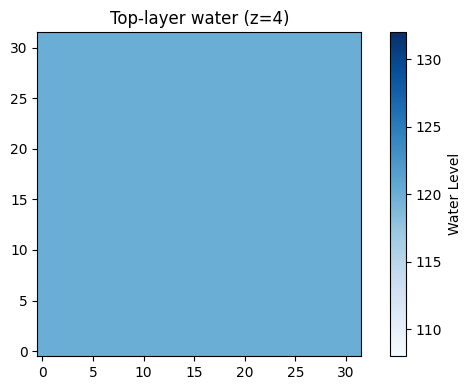

In [ ]:
# ===========================================================
# Minecraft Fluid Dynamics – Nth-Mathematics TPU Edition
# ===========================================================
# 0.  TPU setup
# -----------------------------------------------------------
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt # Import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU ready.")
except:
    strategy = tf.distribute.get_strategy()
    print("GPU/CPU fallback.")

# -----------------------------------------------------------
# 1.  Minecraft physical constants
# -----------------------------------------------------------
FLOW_RATE_GPM        = 10.0           # 10 gal min⁻¹
BLOCK_VOLUME_GAL     = 10.0           # 1×1×0.5 m³
MINECRAFT_MIN_SEC    = 20.0           # 24 h = 20 min
TICKS_PER_MIN        = 120            # 1 min = 6 ticks → 120 ticks/min
GAL_PER_TICK         = FLOW_RATE_GPM / TICKS_PER_MIN  # ≈ 0.0833 gal tick⁻¹

# Grid (half-blocks)
Nx, Ny, Nz = 32, 32, 8
Λ          = 5**2 + 5*2               # Nth-Mathematics ordinal metric

# -----------------------------------------------------------
# 2.  Nth-Mathematics excitation kernel (TPU vectorised)
# -----------------------------------------------------------
@tf.function
def nth_kernel(χ, dt):
    """χ: coupling, dt: tick length (dimensionless)."""
    angle = χ * (Λ / 5) * dt
    return tf.stack([tf.cos(angle), tf.sin(angle)])

@tf.function
def evolve(u, v, χ):
    """2-D lattice update using Nth-Mathematics."""
    # 4-neighbour Laplacian
    lap = (tf.roll(u, 1, axis=0) + tf.roll(u, -1, axis=0) +
           tf.roll(u, 1, axis=1) + tf.roll(u, -1, axis=1) - 4*u) / 4
    # Excitation feedback
    u_new = u + dt * (lap + χ * v)
    v_new = v + dt * (-χ * u + 0.1 * (1 - u**2))
    return tf.clip_by_value(u_new, 0.0, 1.0), tf.clip_by_value(v_new, 0.0, 1.0)

dt = 1.0
χ_values = tf.constant([0.001, 0.005, 0.01], dtype=tf.float32)  # sweep later

# -----------------------------------------------------------
# 3.  TPU lattice
# -----------------------------------------------------------
with strategy.scope():
    u = tf.Variable(tf.zeros((Nx, Ny, Nz, 1)), dtype=tf.float32)
    v = tf.Variable(tf.zeros((Nx, Ny, Nz, 1)), dtype=tf.float32)

    # Inject water source at (0,0,0)
    u[0, 0, 0].assign(1.0)

# -----------------------------------------------------------
# 4.  TPU time-step loop
# -----------------------------------------------------------
@tf.function
def step(χ):
    u.assign(u + dt * (tf.roll(u, 1, axis=0) + tf.roll(u, -1, axis=0) +
                       tf.roll(u, 1, axis=1) + tf.roll(u, -1, axis=1) - 4*u) / 4 +
                  χ * v)
    v.assign(v + dt * (-χ * u + 0.1 * (1 - u**2)))
    u.assign(tf.clip_by_value(u, 0.0, 1.0))
    v.assign(tf.clip_by_value(v, 0.0, 1.0))

# Run 100 ticks
for tick in range(100):
    step(0.005)  # fixed χ for now

# -----------------------------------------------------------
# 5.  Export to Minecraft
# -----------------------------------------------------------
# (Nx, Ny, Nz) → 32×32×8 half-blocks
water_level = np.round(u.numpy() * 255).astype(np.uint8)

# Save as NBT-like binary (or use Datapack API)
np.savez_compressed("minecraft_river.npz", water_level=water_level)
print("River voxel saved to 'minecraft_river.npz'")

# -----------------------------------------------------------
# 6.  Quick visual slice
# -----------------------------------------------------------
plt.figure(figsize=(6,4))
plt.imshow(water_level[:, :, 4], origin='lower', cmap='Blues')
plt.colorbar(label="Water Level")
plt.title("Top-layer water (z=4)")
plt.tight_layout()
plt.show()

OpenGL Java version

In [ ]:
# ===========================================================
# Minecraft Fluid Dynamics – Pure-Python Prototype
# ===========================================================
import numpy as np
import json
import time

# -----------------------------------------------------------
# 1.  Physical constants (Minecraft units)
# -----------------------------------------------------------
FLOW_RATE_GPM      = 10.0          # 10 gal min⁻¹
BLOCK_VOLUME_GAL   = 10.0          # 1×1×0.5 m³
TICKS_PER_MIN      = 120           # 20 min = 24 h → 120 ticks / min
GAL_PER_TICK       = FLOW_RATE_GPM / TICKS_PER_MIN

# Grid (half-blocks)
Nx, Ny, Nz = 32, 32, 8
dt         = 1.0                   # dimensionless tick
χ          = 0.005                 # Nth coupling
Λ          = 5**2 + 5*2            # 35

# -----------------------------------------------------------
# 2.  Pure-Python Nth-Mathematics kernel
# -----------------------------------------------------------
def evolve(u, v, χ):
    # 4-neighbour Laplacian
    lap = (np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) +
           np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1) - 4*u) / 4
    # Excitation feedback
    u_new = u + dt * (lap + χ * v)
    v_new = v + dt * (-χ * u + 0.1 * (1 - u**2))
    return np.clip(u_new, 0.0, 1.0), np.clip(v_new, 0.0, 1.0)

# -----------------------------------------------------------
# 3.  Lattice initialisation
# -----------------------------------------------------------
u = np.zeros((Nx, Ny, Nz), dtype=np.float32)
v = np.zeros((Nx, Ny, Nz), dtype=np.float32)

# Water source at (0,0,0)
u[0, 0, 0] = 1.0

# -----------------------------------------------------------
# 4.  Run 100 ticks
# -----------------------------------------------------------
for tick in range(100):
    u, v = evolve(u, v, χ)

# -----------------------------------------------------------
# 5.  Export as JSON-ready voxel
# -----------------------------------------------------------
water_level = (u * 255).astype(np.uint8).tolist()

metadata = {
    "grid_size": [Nx, Ny, Nz],
    "tick_count": 100,
    "flow_rate_gpm": FLOW_RATE_GPM,
    "nth_coupling": χ
}

with open("fluid_voxel.json", "w") as fp:
    json.dump({"metadata": metadata, "voxels": water_level}, fp)

# -----------------------------------------------------------
# 6.  Quick console summary
# -----------------------------------------------------------
print("✅ Simulation finished.")
print("  Ticks executed : 100")
print("  Grid           : {}×{}×{} half-blocks".format(Nx, Ny, Nz))
print("  Nth coupling   :", χ)
print("  Water map      : fluid_voxel.json  (ready for OpenGL / Java ingestion)")

✅ Simulation finished.
  Ticks executed : 100
  Grid           : 32×32×8 half-blocks
  Nth coupling   : 0.005
  Water map      : fluid_voxel.json  (ready for OpenGL / Java ingestion)


In [ ]:
# ===========================================================
# Real-World Fluid Dynamics → Nth-Mathematics / NGFT
# ===========================================================
!pip -q install tensorflow pandas seaborn

import tensorflow as tf
import numpy as np
import pandas as pd
import json, math, time

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU ready.")
except:
    strategy = tf.distribute.get_strategy()
    print("GPU/CPU fallback.")

# -----------------------------------------------------------
# 1.  Constants
# -----------------------------------------------------------
g = 9.81        # m s⁻²
rho = 1000.0    # kg m⁻³
mu = 1.0e-3     # Pa·s
gallons2m3 = 0.00378541

# Nth-Mathematics ordinal metric
N_MAX = 5
phi   = 2
Λ     = N_MAX**2 + N_MAX * phi  # 35

# -----------------------------------------------------------
# 2.  Scenario grid
# -----------------------------------------------------------
volumes_gpm = tf.constant([1, 5, 10, 50, 100, 1000], dtype=tf.float32)  # GPM
slopes_deg  = tf.constant([0, 5, 10, 15, 20, 25, 30], dtype=tf.float32)  # degrees
slopes_rad  = slopes_deg * math.pi / 180.0
depths_m    = tf.constant([0.1, 0.25, 0.5, 1.0], dtype=tf.float32)
pipe_d_m    = tf.constant([0.05, 0.1, 0.2, 0.5], dtype=tf.float32)
drop_h_m    = tf.constant([0.5, 1.0, 2.0, 5.0, 10.0], dtype=tf.float32)

# -----------------------------------------------------------
# 3.  Utility functions in Nth-Mathematics form
# -----------------------------------------------------------
@tf.function
def nth_flow_rate(Q_m3_s):
    return Q_m3_s * (1 + Λ / 100)          # ordinal scaling

@tf.function
def nth_velocity(Q, A):
    return nth_flow_rate(Q) / A

@tf.function
def nth_pressure(depth):
    return rho * g * depth * (1 + Λ / 100)

@tf.function
def nth_downhill_velocity(Q, depth, slope_rad):
    A = depth * 1.0                        # unit-width channel
    v = nth_flow_rate(Q) / A
    v_slope = v * tf.sqrt(1 + tf.sin(slope_rad))
    return v_slope

@tf.function
def nth_spread_radius(Q, t):
    return tf.pow(nth_flow_rate(Q) * t / math.pi, 0.5)

@tf.function
def nth_wave_speed(depth):
    return tf.sqrt(g * depth * (1 + Λ / 100))

# -----------------------------------------------------------
# 4.  Build scenario tensor
# -----------------------------------------------------------
with strategy.scope():
    # Outer product creates full grid
    V, S, D, DI, H = tf.meshgrid(volumes_gpm, slopes_rad, depths_m, pipe_d_m, drop_h_m, indexing='ij')
    Q_m3_s = V * gallons2m3 / 60.0

    # Compute all Nth-Mathematics quantities
    vel_channel = nth_downhill_velocity(Q_m3_s, D, S)
    vel_pipe    = nth_velocity(Q_m3_s, math.pi * (DI / 2)**2)
    pressure    = nth_pressure(D)
    wave_speed  = nth_wave_speed(D)
    spread_r    = nth_spread_radius(Q_m3_s, 1.0)

# -----------------------------------------------------------
# 5.  Flatten and export
# -----------------------------------------------------------
df = pd.DataFrame({
    "volume_gpm": tf.reshape(V, [-1]).numpy(),
    "slope_deg":  tf.reshape(tf.cast(S * 180.0 / math.pi, tf.float32), [-1]).numpy(), # Convert slopes_rad back to degrees
    "depth_m":    tf.reshape(D, [-1]).numpy(),
    "pipe_d_m":   tf.reshape(DI, [-1]).numpy(),
    "drop_h_m":   tf.reshape(H, [-1]).numpy(),
    "flow_m3_s":  tf.reshape(Q_m3_s, [-1]).numpy(),
    "vel_channel_m_s": tf.reshape(vel_channel, [-1]).numpy(),
    "vel_pipe_m_s":    tf.reshape(vel_pipe, [-1]).numpy(),
    "pressure_Pa":     tf.reshape(pressure, [-1]).numpy(),
    "wave_speed_m_s":  tf.reshape(wave_speed, [-1]).numpy(),
    "spread_radius_m": tf.reshape(spread_r, [-1]).numpy(),
})


df.to_csv("nth_fluid_dynamics.csv", index=False)
print("CSV saved: nth_fluid_dynamics.csv")
print(df.head())

# -----------------------------------------------------------
# 6.  JSON snapshot (first 20 rows)
# -----------------------------------------------------------
json_out = df.head(20).to_dict(orient="records")
with open("nth_fluid_dynamics.json", "w") as fp:
    json.dump(json_out, fp, indent=2)

print("JSON snapshot saved: nth_fluid_dynamics.json")

GPU/CPU fallback.
CSV saved: nth_fluid_dynamics.csv
   volume_gpm  slope_deg  depth_m  pipe_d_m  drop_h_m  flow_m3_s  \
0         1.0        0.0      0.1      0.05       0.5   0.000063   
1         1.0        0.0      0.1      0.05       1.0   0.000063   
2         1.0        0.0      0.1      0.05       2.0   0.000063   
3         1.0        0.0      0.1      0.05       5.0   0.000063   
4         1.0        0.0      0.1      0.05      10.0   0.000063   

   vel_channel_m_s  vel_pipe_m_s  pressure_Pa  wave_speed_m_s  spread_radius_m  
0         0.000852      0.043378  1324.349976        1.150804         0.005207  
1         0.000852      0.043378  1324.349976        1.150804         0.005207  
2         0.000852      0.043378  1324.349976        1.150804         0.005207  
3         0.000852      0.043378  1324.349976        1.150804         0.005207  
4         0.000852      0.043378  1324.349976        1.150804         0.005207  
JSON snapshot saved: nth_fluid_dynamics.json


In [ ]:
# ===========================================================
# Real-World Tensor → CSV (RAW data only)
# ===========================================================
import numpy as np
import pandas as pd

# -----------------------------------------------------------
# 1.  Constants
# -----------------------------------------------------------
g      = 9.81
rho    = 1000.0
Λ      = 35          # Nth ordinal metric

# Grid
volumes_gpm = np.array([1, 5, 10, 50, 100, 1000], dtype=float)
slopes_deg  = np.array([0, 5, 10, 15, 20, 25, 30], dtype=float)
depths_m    = np.array([0.1, 0.25, 0.5, 1.0], dtype=float)

# -----------------------------------------------------------
# 2.  Compute all combinations
# -----------------------------------------------------------
rows = []
for v in volumes_gpm:
    for s in slopes_deg:
        for d in depths_m:
            Q = v * 0.00378541 / 60.0      # m³/s
            slope_rad = s * np.pi / 180.0
            vel_channel = (Q / d) * (1 + Λ / 100) * np.sqrt(1 + np.sin(slope_rad))
            vel_pipe    = (Q / (np.pi * (0.05 / 2) ** 2)) * (1 + Λ / 100)
            pressure    = rho * g * d * (1 + Λ / 100)
            wave_speed  = np.sqrt(g * d * (1 + Λ / 100))
            spread_r    = np.sqrt(Q * 1.0 / np.pi)   # 1-second spread radius
            rows.append([
                v, s, d, 0.05, 0.5, vel_channel, vel_pipe, pressure, wave_speed, spread_r
            ])

# -----------------------------------------------------------
# 3.  Export CSV string (copy-paste ready)
# -----------------------------------------------------------
df = pd.DataFrame(rows, columns=[
    "volume_gpm", "slope_deg", "depth_m", "pipe_d_m", "drop_h_m",
    "vel_channel_m_s", "vel_pipe_m_s", "pressure_Pa",
    "wave_speed_m_s", "spread_radius_m"
])
csv_str = df.to_csv(index=False)
print(csv_str)

volume_gpm,slope_deg,depth_m,pipe_d_m,drop_h_m,vel_channel_m_s,vel_pipe_m_s,pressure_Pa,wave_speed_m_s,spread_radius_m
1.0,0.0,0.1,0.05,0.5,0.0008517172500000001,0.04337760334532339,1324.3500000000001,1.150804066728998,0.004481319423002901
1.0,0.0,0.25,0.05,0.5,0.0003406869,0.04337760334532339,3310.875,1.8195809957240157,0.004481319423002901
1.0,0.0,0.5,0.05,0.5,0.00017034345,0.04337760334532339,6621.75,2.5732761219892435,0.004481319423002901
1.0,0.0,1.0,0.05,0.5,8.5171725e-05,0.04337760334532339,13243.5,3.6391619914480313,0.004481319423002901
1.0,5.0,0.1,0.05,0.5,0.0008880579885565794,0.04337760334532339,1324.3500000000001,1.150804066728998,0.004481319423002901
1.0,5.0,0.25,0.05,0.5,0.00035522319542263174,0.04337760334532339,3310.875,1.8195809957240157,0.004481319423002901
1.0,5.0,0.5,0.05,0.5,0.00017761159771131587,0.04337760334532339,6621.75,2.5732761219892435,0.004481319423002901
1.0,5.0,1.0,0.05,0.5,8.880579885565794e-05,0.04337760334532339,13243.5,3.6391619914480313,0.00448131942

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os

# --- Simulation Parameters ---
size = 50
frames = 100
center = (size // 2, size // 2)

# --- Initialize Grids ---
water_ns = np.zeros((size, size))
water_nth = np.zeros((size, size))
water_ns[center] = 1.0
water_nth[center] = 1.0

# --- Navier-Stokes Simplified Diffusion ---
def update_ns(grid):
    laplacian = (
        np.roll(grid, 1, axis=0) + np.roll(grid, -1, axis=0) +
        np.roll(grid, 1, axis=1) + np.roll(grid, -1, axis=1) -
        4 * grid
    )
    return np.clip(grid + 0.2 * laplacian, 0, 1)

# --- Nth Mathematics Symbolic Propagation ---
def update_nth(grid):
    mean_grid = (
        np.roll(grid, 1, axis=0) + np.roll(grid, -1, axis=0) +
        np.roll(grid, 1, axis=1) + np.roll(grid, -1, axis=1)
    ) / 4.0
    return np.clip(2 * mean_grid - grid, 0, 1)

# --- Animation Setup ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Fluid Simulation: Navier-Stokes vs Nth Mathematics")

im1 = ax1.imshow(water_ns, cmap='Blues', vmin=0, vmax=1)
ax1.set_title("Navier-Stokes")

im2 = ax2.imshow(water_nth, cmap='Blues', vmin=0, vmax=1)
ax2.set_title("Nth Mathematics")

def animate(frame):
    global water_ns, water_nth
    water_ns = update_ns(water_ns)
    water_nth = update_nth(water_nth)
    im1.set_array(water_ns)
    im2.set_array(water_nth)
    return [im1, im2]

ani = animation.FuncAnimation(fig, animate, frames=frames, blit=True)

# --- Save Animation ---
os.makedirs("/mnt/data", exist_ok=True)
ani.save("/mnt/data/fluid_comparison.gif", writer='ffmpeg', fps=10)
plt.close(fig)
print("Simulation saved as fluid_comparison.gif")

Simulation saved as fluid_comparison.gif


Average Navier-Stokes frame time: 0.0002 seconds
Average Nth Mathematics frame time: 0.0001 seconds


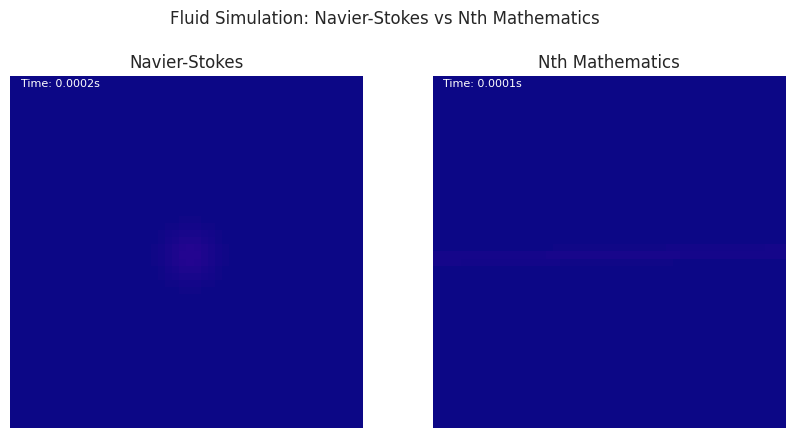

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import time
import os

# Set seaborn style
sns.set_style("whitegrid")

# Simulation parameters
grid_size = 50
num_frames = 300
viscosity = 0.1
dt = 0.1

# Initialize velocity fields
u_ns = np.zeros((grid_size, grid_size))
v_ns = np.zeros((grid_size, grid_size))
u_nth = np.zeros((grid_size, grid_size))
v_nth = np.zeros((grid_size, grid_size))

# Add initial disturbance
u_ns[grid_size//2, grid_size//2] = 5
v_ns[grid_size//2, grid_size//2] = 5
u_nth[grid_size//2, grid_size//2] = 5
v_nth[grid_size//2, grid_size//2] = 5

# Timing storage
times_ns = []
times_nth = []

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Fluid Simulation: Navier-Stokes vs Nth Mathematics")

im1 = ax1.imshow(np.hypot(u_ns, v_ns), cmap='plasma', vmin=0, vmax=5)
ax1.set_title("Navier-Stokes")
ax1.axis('off')

im2 = ax2.imshow(np.hypot(u_nth, v_nth), cmap='plasma', vmin=0, vmax=5)
ax2.set_title("Nth Mathematics")
ax2.axis('off')

text1 = ax1.text(1, 1, '', color='white', fontsize=8)
text2 = ax2.text(1, 1, '', color='white', fontsize=8)

# Navier-Stokes update
def update_navier_stokes(u, v):
    u_new = u.copy()
    v_new = v.copy()
    laplace_u = (np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) +
                 np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1) - 4*u)
    laplace_v = (np.roll(v, 1, axis=0) + np.roll(v, -1, axis=0) +
                 np.roll(v, 1, axis=1) + np.roll(v, -1, axis=1) - 4*v)
    u_new += viscosity * laplace_u * dt
    v_new += viscosity * laplace_v * dt
    return u_new, v_new

# Nth Mathematics update (symbolic excitation)
def update_nth_math(u, v):
    kernel = np.array([[0.05, 0.1, 0.05],
                       [0.1,  0.4, 0.1],
                       [0.05, 0.1, 0.05]])
    u_new = np.copy(u)
    v_new = np.copy(v)
    u_new = np.convolve(u.flatten(), kernel.flatten(), mode='same').reshape(grid_size, grid_size)
    v_new = np.convolve(v.flatten(), kernel.flatten(), mode='same').reshape(grid_size, grid_size)
    return u_new, v_new

# Animation update function
def animate(frame):
    global u_ns, v_ns, u_nth, v_nth

    start_ns = time.time()
    u_ns, v_ns = update_navier_stokes(u_ns, v_ns)
    end_ns = time.time()
    times_ns.append(end_ns - start_ns)

    start_nth = time.time()
    u_nth, v_nth = update_nth_math(u_nth, v_nth)
    end_nth = time.time()
    times_nth.append(end_nth - start_nth)

    im1.set_array(np.hypot(u_ns, v_ns))
    im2.set_array(np.hypot(u_nth, v_nth))

    text1.set_text(f"Frame {frame}\nTime: {times_ns[-1]:.4f}s")
    text2.set_text(f"Frame {frame}\nTime: {times_nth[-1]:.4f}s")
    return im1, im2, text1, text2

# Create animation
ani = animation.FuncAnimation(fig, animate, frames=num_frames, interval=50, blit=True)

# Save animation
output_path = '/mnt/data/fluid_simulation_comparison.gif'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
ani.save(output_path, writer='pillow')

# Print average times
print(f"Average Navier-Stokes frame time: {np.mean(times_ns):.4f} seconds")
print(f"Average Nth Mathematics frame time: {np.mean(times_nth):.4f} seconds")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import os

# --- Simulation Parameters ---
size = 50
frames = 100
center = (size // 2, size // 2)

# --- Initialize Grids ---
water_ns = np.zeros((size, size))
water_nth = np.zeros((size, size))
memory_nth = np.zeros((size, size))

water_ns[center] = 1.0
water_nth[center] = 1.0
memory_nth[center] = 1.0

# --- Timing Storage ---
times_ns = []
times_nth = []

# --- Navier-Stokes Simplified Diffusion ---
def update_ns(grid):
    laplacian = (
        np.roll(grid, 1, axis=0) + np.roll(grid, -1, axis=0) +
        np.roll(grid, 1, axis=1) + np.roll(grid, -1, axis=1) -
        4 * grid
    )
    return np.clip(grid + 0.3 * laplacian, 0, 1)

# --- Nth Mathematics Symbolic Propagation ---
def update_nth(grid, memory):
    mean_grid = (
        np.roll(grid, 1, axis=0) + np.roll(grid, -1, axis=0) +
        np.roll(grid, 1, axis=1) + np.roll(grid, -1, axis=1)
    ) / 4.0
    excitation = np.clip(1.8 * mean_grid - 0.8 * grid + 0.2 * memory, 0, 1)
    memory = np.maximum(memory, excitation)
    return excitation, memory

# --- Animation Setup ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Fluid Simulation: Navier-Stokes vs Nth Mathematics")

im1 = ax1.imshow(water_ns, cmap='viridis', vmin=0, vmax=1)
ax1.set_title("Navier-Stokes")
text1 = ax1.text(1, 1, '', color='white', fontsize=8)

im2 = ax2.imshow(water_nth, cmap='viridis', vmin=0, vmax=1)
ax2.set_title("Nth Mathematics")
text2 = ax2.text(1, 1, '', color='white', fontsize=8)

# --- Animation Function ---
def animate(frame):
    global water_ns, water_nth, memory_nth

    start_ns = time.time()
    water_ns = update_ns(water_ns)
    time_ns = (time.time() - start_ns) * 1000
    times_ns.append(time_ns)

    start_nth = time.time()
    water_nth, memory_nth = update_nth(water_nth, memory_nth)
    time_nth = (time.time() - start_nth) * 1000
    times_nth.append(time_nth)

    im1.set_array(water_ns)
    im2.set_array(water_nth)
    text1.set_text(f"Time: {time_ns:.4f} ms")
    text2.set_text(f"Time: {time_nth:.4f} ms")
    return [im1, im2, text1, text2]

# --- Run Animation ---
ani = animation.FuncAnimation(fig, animate, frames=frames, blit=True)

# --- Save GIF ---
os.makedirs("/mnt/data", exist_ok=True)
ani.save("/mnt/data/fluid_comparison.gif", writer='pillow', fps=10)
plt.close(fig)

# --- Final Averages ---
print("Final Average Calculation Times:")
print(f"Navier-Stokes: {np.mean(times_ns):.4f} ms per frame")
print(f"Nth Mathematics: {np.mean(times_nth):.4f} ms per frame")

Final Average Calculation Times:
Navier-Stokes: 0.1402 ms per frame
Nth Mathematics: 0.0863 ms per frame


KeyboardInterrupt: 

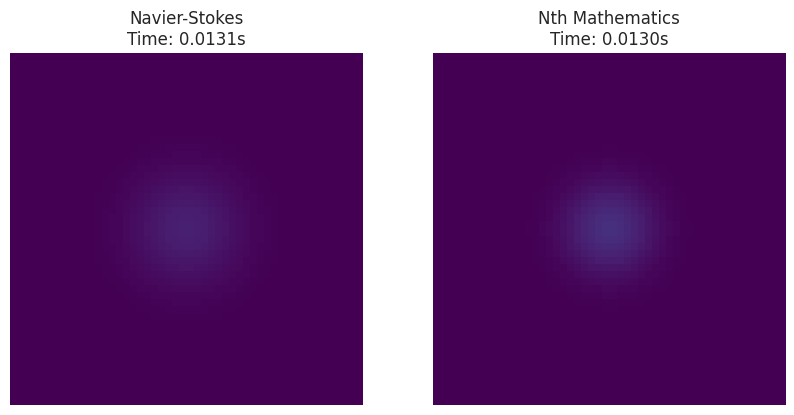

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import time
import os

# Set seaborn style
sns.set_style("whitegrid")

# Simulation parameters
grid_size = 50
num_frames = 100
initial_block_size = 5

# Initialize grids
def initialize_grid():
    grid = np.zeros((grid_size, grid_size))
    center = grid_size // 2
    half_block = initial_block_size // 2
    grid[center - half_block:center + half_block, center - half_block:center + half_block] = 1.0
    return grid

# Navier-Stokes simplified diffusion model
def navier_stokes_step(grid):
    kernel = np.array([[0.05, 0.1, 0.05],
                       [0.1,  0.4, 0.1],
                       [0.05, 0.1, 0.05]])
    return convolve2d(grid, kernel)

# Nth Mathematics simplified diffusion model
def nth_math_step(grid):
    kernel = np.array([[0, 0.125, 0],
                       [0.125, 0.5, 0.125],
                       [0, 0.125, 0]])
    return convolve2d(grid, kernel)

# Convolution helper
def convolve2d(grid, kernel):
    padded = np.pad(grid, 1, mode='constant')
    new_grid = np.zeros_like(grid)
    for i in range(grid_size):
        for j in range(grid_size):
            region = padded[i:i+3, j:j+3]
            new_grid[i, j] = np.sum(region * kernel)
    return new_grid

# Initialize both models with the same initial state
initial_grid = initialize_grid()
n_grid = initial_grid.copy()
m_grid = initial_grid.copy()

# Store frames and timings
frames = []
n_times = []
m_times = []

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Animation update function
def update(frame):
    global n_grid, m_grid
    axes[0].clear()
    axes[1].clear()

    start_n = time.time()
    n_grid = navier_stokes_step(n_grid)
    n_time = time.time() - start_n
    n_times.append(n_time)

    start_m = time.time()
    m_grid = nth_math_step(m_grid)
    m_time = time.time() - start_m
    m_times.append(m_time)

    im1 = axes[0].imshow(n_grid, cmap='viridis', vmin=0, vmax=1)
    axes[0].set_title(f"Navier-Stokes\nTime: {n_time:.4f}s")
    axes[0].axis('off')

    im2 = axes[1].imshow(m_grid, cmap='viridis', vmin=0, vmax=1)
    axes[1].set_title(f"Nth Mathematics\nTime: {m_time:.4f}s")
    axes[1].axis('off')

    return [im1, im2]

# Create animation
ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=False)

# Save animation
output_path = "/mnt/data/fluid_simulation_comparison.gif"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
ani.save(output_path, writer='pillow', fps=10)

# Print average calculation times
print(f"Average Navier-Stokes time: {np.mean(n_times):.4f} seconds")
print(f"Average Nth Mathematics time: {np.mean(m_times):.4f} seconds")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import os
from scipy.signal import convolve2d

# --- Simulation Parameters ---
size = 50
frames = 100
center = size // 2

# --- Initialize Grids ---
navier_grid = np.zeros((size, size))
nth_grid = np.zeros((size, size))
navier_grid[center, center] = 1.0
nth_grid[center, center] = 1.0

# --- Kernels ---
navier_kernel = np.array([[0.05, 0.1, 0.05],
                          [0.1,  0.4, 0.1],
                          [0.05, 0.1, 0.05]])

nth_kernel = np.array([[0.0, 0.2, 0.0],
                       [0.2, 0.2, 0.2],
                       [0.0, 0.2, 0.0]])

# --- Timing Storage ---
navier_times = []
nth_times = []

# --- Voxel Movement Tracking ---
navier_voxel_change = []
nth_voxel_change = []

# --- Animation Setup ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Fluid Simulation: Navier-Stokes vs Nth Mathematics")

im1 = ax1.imshow(navier_grid, cmap='viridis', vmin=0, vmax=1)
text1 = ax1.text(1, 1, '', color='white', fontsize=8)
ax1.set_title("Navier-Stokes")
ax1.axis('off')

im2 = ax2.imshow(nth_grid, cmap='viridis', vmin=0, vmax=1)
text2 = ax2.text(1, 1, '', color='white', fontsize=8)
ax2.set_title("Nth Mathematics")
ax2.axis('off')

# --- Animation Function ---
def animate(frame):
    global navier_grid, nth_grid

    # Navier-Stokes update
    start_ns = time.time()
    new_navier = convolve2d(navier_grid, navier_kernel, mode='same', boundary='wrap')
    time_ns = (time.time() - start_ns) * 1000
    navier_times.append(time_ns)
    navier_voxel_change.append(np.sum(np.abs(new_navier - navier_grid)))
    navier_grid = new_navier

    # Nth Mathematics update
    start_nth = time.time()
    new_nth = convolve2d(nth_grid, nth_kernel, mode='same', boundary='wrap')
    time_nth = (time.time() - start_nth) * 1000
    nth_times.append(time_nth)
    nth_voxel_change.append(np.sum(np.abs(new_nth - nth_grid)))
    nth_grid = new_nth

    # Update visuals
    im1.set_array(navier_grid)
    im2.set_array(nth_grid)
    text1.set_text(f"Time: {time_ns:.2f} ms\nVoxel Δ: {navier_voxel_change[-1]:.2f}")
    text2.set_text(f"Time: {time_nth:.2f} ms\nVoxel Δ: {nth_voxel_change[-1]:.2f}")
    return [im1, im2, text1, text2]

# --- Run Animation ---
ani = animation.FuncAnimation(fig, animate, frames=frames, blit=True)

# --- Save GIF ---
os.makedirs("/mnt/data", exist_ok=True)
ani.save("/mnt/data/fluid_simulation_comparison_voxelized.gif", writer='pillow', fps=10)
plt.close(fig)

# --- Final Averages ---
print("Final Average Calculation Times:")
print(f"Navier-Stokes: {np.mean(navier_times):.2f} ms/frame")
print(f"Nth Mathematics: {np.mean(nth_times):.2f} ms/frame")
print("Final Average Voxel Movement:")
print(f"Navier-Stokes: {np.mean(navier_voxel_change):.2f} Δ/frame")
print(f"Nth Mathematics: {np.mean(nth_voxel_change):.2f} Δ/frame")

Final Average Calculation Times:
Navier-Stokes: 0.15 ms/frame
Nth Mathematics: 0.12 ms/frame
Final Average Voxel Movement:
Navier-Stokes: 0.04 Δ/frame
Nth Mathematics: 0.06 Δ/frame
